In [153]:
# importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import xgboost as xgb
from sklearn.model_selection import KFold

# Data Processing

In [154]:
# Reading data into a dataframe
df = pd.read_csv('data_train-1.csv')

# printing the first 5 rows of the data
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001518,Male,Yes,1,Graduate,No,1538,1425.0,30.0,360.0,1.0,Urban,Y
1,1,LP002734,Male,Yes,0,Graduate,No,6133,3906.0,324.0,360.0,1.0,Urban,Y
2,2,LP002697,Male,No,0,Graduate,No,4680,2087.0,NaN,360.0,1.0,Semiurban,N
3,3,LP002455,Male,Yes,2,Graduate,No,3859,0.0,96.0,360.0,1.0,Semiurban,Y
4,4,LP001732,Male,Yes,2,Graduate,NaN,5000,0.0,72.0,360.0,0.0,Semiurban,N


In [155]:
# printing the shape of the dataframe
print("Shape of the data", df.shape)

# printing the actual shape of the dataframe
df = df.iloc[:, 1:]
print("Actual size of data", df.shape)

Shape of the data (491, 14)
Actual size of data (491, 13)


This dataset contains information about loan applicants, including their gender, marital status, number of dependents, education level, employment status, income, loan amount, loan term, credit history, property area, and loan status. Each row represents a single applicant.

The dataset appears to have some missing values which were imputed based on mean for continuous varaibles and based on most frequent entries for categorical variables. This may induce some bias but removing all the rows with missing values may not be the optimal way because the dataset is small.

The dataset contains categorical variables with binary values, i.e. "Yes" or "No", "Graduated" or "Not Graduated", and categorical variables with distinct classes (2 or 3) in case of Property Area - "Rural", "Urban", "Semi Urban".
Whereas, to train a classfication tree numerical inputs are required. Thus encoding of the categorical data is mandatory. A mapping between Categorical variable and a set of numeric values were established and the data was transformed to a numeric based dataset.

In [156]:
print("Yes the data has some missing values \n")

# Counting missing values in each column
blank_sum_row = df.isnull().sum()
print("Total Blank Rows:\n", blank_sum_row)

# Counting total missing values
blank_sum = df.isnull().sum().sum()
print("Total Blank places:", blank_sum)

Yes the data has some missing values 

Total Blank Rows:
 Loan_ID               0
Gender               12
Married               3
Dependents           13
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           17
Loan_Amount_Term     12
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64
Total Blank places: 129


In [157]:
# Separate the dataset into categorical and continuous columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status']
continuous_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History']

print("\n Categorical Variables:", categorical_cols)
print("\n Continuous Variables:", continuous_cols)


 Categorical Variables: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

 Continuous Variables: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [158]:
categorical_df = df[categorical_cols]
continuous_df = df[continuous_cols]

In [159]:
# Impute missing values in categorical columns with the most frequent category
# categorical_imputer = SimpleImputer(strategy='most_frequent')
# df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
categorical_df.fillna(categorical_df.mode(axis=0), inplace=True)

C:\Users\arun2\AppData\Local\Temp\ipykernel_17172\1460749346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df.fillna(categorical_df.mode(axis=0), inplace=True)


In [160]:
# # Impute missing values in continuous columns with the mean
# continuous_imputer = SimpleImputer(strategy='mean')
# df[continuous_cols] = continuous_imputer.fit_transform(df[continuous_cols])
continuous_df.fillna(continuous_df.mean(), inplace=True)

C:\Users\arun2\AppData\Local\Temp\ipykernel_17172\1187253778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continuous_df.fillna(continuous_df.mean(), inplace=True)


In [161]:
df = pd.concat([continuous_df, categorical_df], axis=1)

In [162]:
print(df)

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               1538             1425.0   30.000000        360.000000   
1               6133             3906.0  324.000000        360.000000   
2               4680             2087.0  146.170886        360.000000   
3               3859                0.0   96.000000        360.000000   
4               5000                0.0   72.000000        360.000000   
..               ...                ...         ...               ...   
486             3410                0.0   88.000000        342.964509   
487             3676             4301.0  172.000000        360.000000   
488             3716                0.0   42.000000        180.000000   
489            81000                0.0  360.000000        360.000000   
490             2764             1459.0  110.000000        360.000000   

     Credit_History  Gender Married Dependents Education Self_Employed  \
0               1.0    Male     Yes          1  G

In [163]:
# Extracting the features
features = df.iloc[:,0:11]
features.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,1538,1425.0,30.000000,360.0,1.0,Male,Yes,1,Graduate,No,Urban
1,6133,3906.0,324.000000,360.0,1.0,Male,Yes,0,Graduate,No,Urban
2,4680,2087.0,146.170886,360.0,1.0,Male,No,0,Graduate,No,Semiurban
3,3859,0.0,96.000000,360.0,1.0,Male,Yes,2,Graduate,No,Semiurban
4,5000,0.0,72.000000,360.0,0.0,Male,Yes,2,Graduate,NaN,Semiurban


In [164]:
# Extracting the labels
labels = df.iloc[:,11:12]
labels.head()

,Loan_Status
0,Y
1,Y
2,N
3,Y
4,N


To train a classfication tree, numerical inputs are required. Thus encoding of the categorical data is mandatory. I'm mapping the Categorical variable to a set of numeric values per the logic below.

In [165]:
# Encoding the data
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['Married'] = df['Married'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Education'] = df['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)
df['Self_Employed'] = df['Self_Employed'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Loan_Status'] = df['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Mapping the categorical variables to numericals 
mapping_propertyarea = {'Rural': 0, 'Semiurban': 1, 'Urban': 2}
df['Property_Area'] = df['Property_Area'].replace(mapping_propertyarea)

# Mapping the categorical variables to numericals
mapping_dependents = {'0': 0, '1': 1, '2': 2, '3+': 3}
df['Dependents'] = df['Dependents'].replace(mapping_dependents)

#print(df)

In [166]:
#encoded_df = pd.get_dummies(df, columns=['Gender','Married','Education','Self_Employed','Property_Area', 'Loan_Status'])

In [167]:
#encoded_df.head()

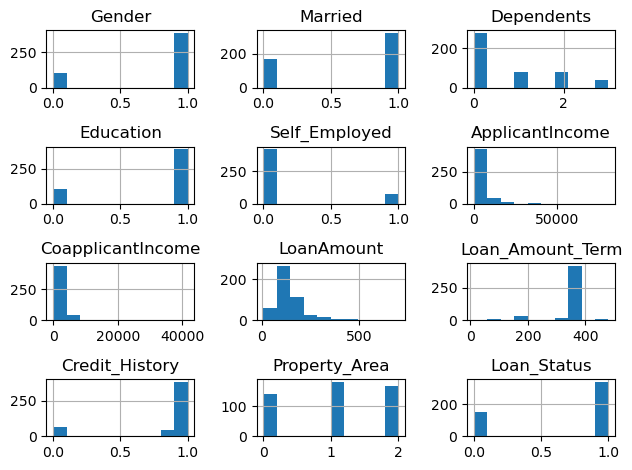

In [168]:
# Selecting features to plot as histogram
features_to_display = ['Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History', 'Property_Area', 'Loan_Status']

# Plotting histogram for all features
df[features_to_display].hist()
plt.tight_layout()
plt.show()

Removing Loan_ID feature as it won't generalize the data well as it is unique, and could add complexity ot the model. Using Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area as the features based on which the tree will split

In [169]:
# Extracting the features after encoding
features = df.iloc[:,0:11]
features.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,1538,1425.0,30.000000,360.0,1.0,1,1,1.0,1,0,2
1,6133,3906.0,324.000000,360.0,1.0,1,1,0.0,1,0,2
2,4680,2087.0,146.170886,360.0,1.0,1,0,0.0,1,0,1
3,3859,0.0,96.000000,360.0,1.0,1,1,2.0,1,0,1
4,5000,0.0,72.000000,360.0,0.0,1,1,2.0,1,0,1


In [170]:
# Extracting the labels after encoding
labels = df.iloc[:,11:12]
labels.head()

,Loan_Status
0,1
1,1
2,0
3,1
4,0


In [171]:
# Splitting dataset into training and validation sets. (80% data for training and 20% validation)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [172]:
# Converting the dataframes to numpy arrays for processing
X_train_array = X_train.to_numpy()
X_val_array = X_val.to_numpy()
y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()

In [173]:
# print(X_train_array.shape)
# print(X_val_array.shape)
# print(y_train_array.shape)
# print(y_val_array.shape)

In [174]:
# y_val_array = np.where(y_val_array=='Y', 1, 0)
# y_train_array = np.where(y_train_array=='Y', 1, 0)

In [175]:
print(y_train_array)

[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]


# Part A - Classification Tree

In [176]:
class TreeNode():
    def __init__(self, feature_id=None, threshold=None, left=None, right=None, impurity_gini=None, value=None):
        ''' Constructor for the tree node ''' 
        
        self.feature_id = feature_id
        self.threshold = threshold
        self.left = left
        self.right = right
        self.impurity_gini = impurity_gini
        self.value = value

In [177]:
class DecisionTree():
    
    def __init__(self, min_samples_split=2, max_depth=2): 
        ''' Constructor for the custom Decision Tree Classifier '''
            
        self.root = None                                     
        self.min_samples_split = min_samples_split           
        self.max_tree_depth = max_depth                      
        
    def fit(self, X, y):
        ''' Function to train the decision tree '''
        
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(data)
        
    def build_tree(self, data, depth=0): 
        ''' Recursive function to build the tree '''
        
        features, labels = data[:, :-1], data[:, -1]
        n_samples, n_features = np.shape(features)
        
        if n_samples >= self.min_samples_split and depth <= self.max_tree_depth:
            best_split = self.find_best_split(data, n_samples, n_features)
            
            if best_split["gini_impurity"] <= 1:
                left_subtree = self.build_tree(best_split["left_data"], depth + 1)
                right_subtree = self.build_tree(best_split["right_data"], depth + 1)
                return TreeNode(best_split["feature_id"], best_split["threshold"], 
                                left_subtree, right_subtree, best_split["gini_impurity"])

        leaf_value = self.calculate_leaf_value(labels)
        return TreeNode(value=leaf_value)
    
    def find_best_split(self, data, n_samples, n_features):
        ''' Function to find the best split '''
        
        best_split = {}
        max_gini_reduction = -float("inf")
        
        for feature_id in range(n_features):
            feature_values = data[:, feature_id]
            unique_thresholds = np.unique(feature_values)
            for threshold in unique_thresholds:
                data_left, data_right = self.split_data(data, feature_id, threshold)
                if len(data_left) > 0 and len(data_right) > 0:
                    labels, left_labels, right_labels = data[:, -1], data_left[:, -1], data_right[:, -1]
                    gini_reduction = self.calculate_gini_reduction(labels, left_labels, right_labels)
                    if gini_reduction > max_gini_reduction:
                        best_split["feature_id"] = feature_id
                        best_split["threshold"] = threshold
                        best_split["left_data"] = data_left
                        best_split["right_data"] = data_right
                        best_split["gini_impurity"] = gini_reduction
                        max_gini_reduction = gini_reduction
                        
        return best_split
    
    def split_data(self, data, feature_id, threshold):
        ''' Function to split the data '''
        
        data_left = np.array([row for row in data if row[feature_id] <= threshold])
        data_right = np.array([row for row in data if row[feature_id] > threshold])
        return data_left, data_right
    
    def calculate_gini_reduction(self, parent, left_child, right_child):
        ''' Function to compute Gini impurity reduction '''
        
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        reduction = self.calculate_gini_index(parent) - (weight_left * self.calculate_gini_index(left_child) + weight_right * self.calculate_gini_index(right_child))
        return reduction
    
    def calculate_gini_index(self, labels):
        ''' Function to compute Gini impurity index '''
        
        unique_classes = np.unique(labels)
        gini = 0
        for cls in unique_classes:
            class_prob = len(labels[labels == cls]) / len(labels)
            gini += class_prob ** 2
        return 1 - gini
        
    def calculate_leaf_value(self, labels):
        ''' Function to compute leaf node value '''
        
        labels = list(labels)
        return max(labels, key=labels.count)
  
    def predict(self, X):
        ''' Function to predict new dataset '''
        
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):
        ''' Function to predict a single data point '''
        
        if tree.value is not None:
            return tree.value
        feature_value = x[tree.feature_id]
        if feature_value <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def accuracy(self, y_true, y_pred):
        ''' Function to compute accuracy '''
        
        correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
        total = len(y_true)
        return correct / total

Best max depth: 1
Accuracy at best max depth: 0.7575757575757576


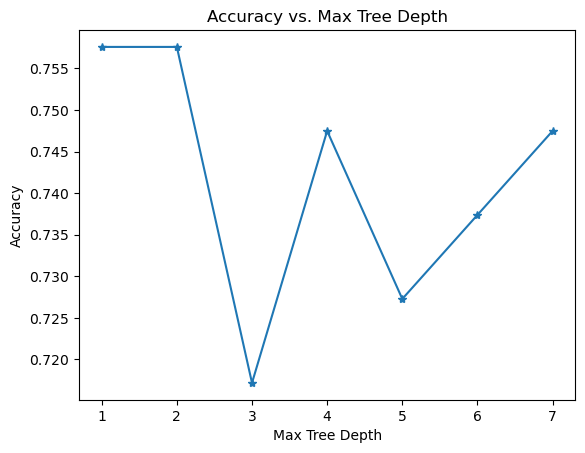

In [178]:
max_tree_depths = range(1, 8)
accuracies = []

for max_depth in max_tree_depths:
    classification_tree = DecisionTree(min_samples_split=2, max_depth=max_depth)   # Decision Tree instance with current max_tree_depth
    classification_tree.fit(X_train_array, y_train_array)   # Fitting classifier on training data
    predictions = classification_tree.predict(X_val_array)  # Pediction in Validation dataset
    accuracy = classification_tree.accuracy(y_val_array, predictions)   # Accuracy Calculation
    accuracies.append(accuracy)

best_max_depth = max_tree_depths[accuracies.index(max(accuracies))]
print(f"Best max depth: {best_max_depth}")
print(f"Accuracy at best max depth: {max(accuracies)}")

# Now, train the model with the best max_depth and make predictions on the test data
best_model = DecisionTree(min_samples_split=2, max_depth=4)
best_model.fit(X_train_array, y_train_array)
y_pred = best_model.predict(X_val_array)
accuracy = best_model.accuracy(y_val_array, y_pred)

# # Plot Accuracy in each depth
plt.plot(max_tree_depths, accuracies, marker='*')
plt.title('Accuracy vs. Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.show()

# Part B - Boosting

In [179]:
# pip install xgboost

In [180]:
def train_XGBoost(x_train: np.ndarray, y_train: np.ndarray, x_val: np.ndarray, y_val: np.ndarray, lambda_vals=[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]):
    auc_xgb = []
    xgb_boost = xgb.XGBClassifier(learning_rate=0.1, objective="binary:logistic")  # Create single XGBoost object

    kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation
    for train_index, val_index in kf.split(x_train):
        x_sample, x_val_sample = x_train[train_index], x_train[val_index]
        y_sample, y_val_sample = y_train[train_index], y_train[val_index]

        for l_val in lambda_vals:
            xgb_boost.set_params(reg_lambda=l_val)                             # Train XGBoost with current lambda
            xgb_boost.fit(x_sample, y_sample, eval_set=[(x_val_sample, y_val_sample)], early_stopping_rounds=20)  # Early stopping

            y_pred = xgb_boost.predict_proba(x_val_sample)[:, 1]               # Find y_pred for validation set
            auc_score = roc_auc_score(y_val_sample, y_pred)
            auc_xgb.append(auc_score)

    lam_vals = {l_val: [] for l_val in lambda_vals}
    for i, auc_score in enumerate(auc_xgb):
        lam_vals[lambda_vals[i % len(lambda_vals)]].append(auc_score)

    xgb_lambda_auc = {lam_val: np.mean(xgboost_auc) for lam_val, xgboost_auc in lam_vals.items()}

    return xgb_lambda_auc

xg_lambda_auc = train_XGBoost(X_train_array, y_train_array, X_val_array, y_val_array)       # Train the model
optimal_lambda = max(xg_lambda_auc, key=xg_lambda_auc.get)                                  # Calculate mean AUCs
print("\n XGBoosting mean AUCs keyed with each lambda:")
print(xg_lambda_auc)
print('\n Optimal Lambda: ', optimal_lambda)

[0]	validation_0-logloss:0.66038
[1]	validation_0-logloss:0.63539
[2]	validation_0-logloss:0.61649
[3]	validation_0-logloss:0.60223
[4]	validation_0-logloss:0.59030
[5]	validation_0-logloss:0.58910
[6]	validation_0-logloss:0.57839
[7]	validation_0-logloss:0.57679
[8]	validation_0-logloss:0.57141
[9]	validation_0-logloss:0.57008
[10]	validation_0-logloss:0.57302
[11]	validation_0-logloss:0.58171
[12]	validation_0-logloss:0.57748
[13]	validation_0-logloss:0.56224
[14]	validation_0-logloss:0.56162
[15]	validation_0-logloss:0.55533
[16]	validation_0-logloss:0.55874
[17]	validation_0-logloss:0.56499
[18]	validation_0-logloss:0.56903
[19]	validation_0-logloss:0.57849
[20]	validation_0-logloss:0.57307
[21]	validation_0-logloss:0.57559
[22]	validation_0-logloss:0.57728
[23]	validation_0-logloss:0.57765
[24]	validation_0-logloss:0.58913
[25]	validation_0-logloss:0.58504
[26]	validation_0-logloss:0.58373
[27]	validation_0-logloss:0.58257
[28]	validation_0-logloss:0.58667
[29]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.63569
[2]	validation_0-logloss:0.61682
[3]	validation_0-logloss:0.60254
[4]	validation_0-logloss:0.59066
[5]	validation_0-logloss:0.58722
[6]	validation_0-logloss:0.57712
[7]	validation_0-logloss:0.57667
[8]	validation_0-logloss:0.57211
[9]	validation_0-logloss:0.56884
[10]	validation_0-logloss:0.57242
[11]	validation_0-logloss:0.57978
[12]	validation_0-logloss:0.57662
[13]	validation_0-logloss:0.56170
[14]	validation_0-logloss:0.56008
[15]	validation_0-logloss:0.55454
[16]	validation_0-logloss:0.55718
[17]	validation_0-logloss:0.56336
[18]	validation_0-logloss:0.57443
[19]	validation_0-logloss:0.57674
[20]	validation_0-logloss:0.57137
[21]	validation_0-logloss:0.57352
[22]	validation_0-logloss:0.57429
[23]	validation_0-logloss:0.57475
[24]	validation_0-logloss:0.58722
[25]	validation_0-logloss:0.58966
[26]	validation_0-logloss:0.58351
[27]	validation_0-logloss:0.58396
[28]	validation_0-logloss:0.58614
[29]	validation_0-logloss:0.58785
[30]	validation_0-loglo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.54068
[9]	validation_0-logloss:0.54000
[10]	validation_0-logloss:0.53916
[11]	validation_0-logloss:0.54522
[12]	validation_0-logloss:0.53973
[13]	validation_0-logloss:0.53808
[14]	validation_0-logloss:0.53485
[15]	validation_0-logloss:0.53616
[16]	validation_0-logloss:0.54282
[17]	validation_0-logloss:0.54260
[18]	validation_0-logloss:0.54274
[19]	validation_0-logloss:0.54340
[20]	validation_0-logloss:0.53830
[21]	validation_0-logloss:0.54245
[22]	validation_0-logloss:0.54392
[23]	validation_0-logloss:0.54543
[24]	validation_0-logloss:0.54275
[25]	validation_0-logloss:0.54574
[26]	validation_0-logloss:0.54851
[27]	validation_0-logloss:0.54605
[28]	validation_0-logloss:0.54692
[29]	validation_0-logloss:0.54894
[30]	validation_0-logloss:0.55238
[31]	validation_0-logloss:0.55460
[32]	validation_0-logloss:0.55949
[33]	validation_0-logloss:0.56256
[0]	validation_0-logloss:0.67162
[1]	validation_0-logloss:0.65146
[2]	validation_0-logloss:0.63453
[3]	validation_0-lo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[41]	validation_0-logloss:0.51615
[42]	validation_0-logloss:0.51634
[0]	validation_0-logloss:0.69044
[1]	validation_0-logloss:0.68606
[2]	validation_0-logloss:0.68127
[3]	validation_0-logloss:0.67695
[4]	validation_0-logloss:0.67274
[5]	validation_0-logloss:0.66866
[6]	validation_0-logloss:0.66474
[7]	validation_0-logloss:0.66089
[8]	validation_0-logloss:0.65744
[9]	validation_0-logloss:0.65418
[10]	validation_0-logloss:0.65101
[11]	validation_0-logloss:0.64797
[12]	validation_0-logloss:0.64498
[13]	validation_0-logloss:0.64208
[14]	validation_0-logloss:0.63929
[15]	validation_0-logloss:0.63601
[16]	validation_0-logloss:0.63285
[17]	validation_0-logloss:0.63101
[18]	validation_0-logloss:0.62923
[19]	validation_0-logloss:0.62629
[20]	validation_0-logloss:0.62461
[21]	validation_0-logloss:0.62298
[22]	validation_0-logloss:0.62073
[23]	validation_0-logloss:0.61874
[24]	validation_0-logloss:0.61680
[25]	validation_0-logloss:0.61536
[26]	validation_0-logloss:0.61352
[27]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-logloss:0.59617
[41]	validation_0-logloss:0.59466
[42]	validation_0-logloss:0.59384
[43]	validation_0-logloss:0.59304
[44]	validation_0-logloss:0.59195
[45]	validation_0-logloss:0.59120
[46]	validation_0-logloss:0.58952
[47]	validation_0-logloss:0.58839
[48]	validation_0-logloss:0.58729
[49]	validation_0-logloss:0.58664
[50]	validation_0-logloss:0.58555
[51]	validation_0-logloss:0.58448
[52]	validation_0-logloss:0.58365
[53]	validation_0-logloss:0.58263
[54]	validation_0-logloss:0.58148
[55]	validation_0-logloss:0.58051
[56]	validation_0-logloss:0.57970
[57]	validation_0-logloss:0.57878
[58]	validation_0-logloss:0.57789
[59]	validation_0-logloss:0.57714
[60]	validation_0-logloss:0.57642
[61]	validation_0-logloss:0.57543
[62]	validation_0-logloss:0.57475
[63]	validation_0-logloss:0.57395
[64]	validation_0-logloss:0.57317
[65]	validation_0-logloss:0.57247
[66]	validation_0-logloss:0.57186
[67]	validation_0-logloss:0.57127
[68]	validation_0-logloss:0.57076
[69]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-logloss:0.67670
[37]	validation_0-logloss:0.67626
[38]	validation_0-logloss:0.67582
[39]	validation_0-logloss:0.67533
[40]	validation_0-logloss:0.67484
[41]	validation_0-logloss:0.67435
[42]	validation_0-logloss:0.67387
[43]	validation_0-logloss:0.67339
[44]	validation_0-logloss:0.67291
[45]	validation_0-logloss:0.67243
[46]	validation_0-logloss:0.67196
[47]	validation_0-logloss:0.67148
[48]	validation_0-logloss:0.67106
[49]	validation_0-logloss:0.67059
[50]	validation_0-logloss:0.67013
[51]	validation_0-logloss:0.66966
[52]	validation_0-logloss:0.66920
[53]	validation_0-logloss:0.66874
[54]	validation_0-logloss:0.66828
[55]	validation_0-logloss:0.66782
[56]	validation_0-logloss:0.66737
[57]	validation_0-logloss:0.66691
[58]	validation_0-logloss:0.66646
[59]	validation_0-logloss:0.66601
[60]	validation_0-logloss:0.66560
[61]	validation_0-logloss:0.66520
[62]	validation_0-logloss:0.66479
[63]	validation_0-logloss:0.66439
[64]	validation_0-logloss:0.66398
[65]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.63377
[2]	validation_0-logloss:0.63182
[3]	validation_0-logloss:0.63459
[4]	validation_0-logloss:0.62719
[5]	validation_0-logloss:0.62254
[6]	validation_0-logloss:0.61911
[7]	validation_0-logloss:0.61281
[8]	validation_0-logloss:0.61417
[9]	validation_0-logloss:0.61396
[10]	validation_0-logloss:0.61480
[11]	validation_0-logloss:0.60973
[12]	validation_0-logloss:0.61076
[13]	validation_0-logloss:0.61591
[14]	validation_0-logloss:0.61876
[15]	validation_0-logloss:0.61738
[16]	validation_0-logloss:0.62146
[17]	validation_0-logloss:0.61664
[18]	validation_0-logloss:0.61896
[19]	validation_0-logloss:0.62089
[20]	validation_0-logloss:0.62226
[21]	validation_0-logloss:0.63249
[22]	validation_0-logloss:0.63113
[23]	validation_0-logloss:0.64704
[24]	validation_0-logloss:0.64799
[25]	validation_0-logloss:0.65259
[26]	validation_0-logloss:0.65524
[27]	validation_0-logloss:0.65985
[28]	validation_0-logloss:0.67044
[29]	validation_0-logloss:0.67414
[30]	validation_0-loglo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-logloss:0.58068
[9]	validation_0-logloss:0.58117
[10]	validation_0-logloss:0.58303
[11]	validation_0-logloss:0.58624
[12]	validation_0-logloss:0.58605
[13]	validation_0-logloss:0.58340
[14]	validation_0-logloss:0.58628
[15]	validation_0-logloss:0.58437
[16]	validation_0-logloss:0.58994
[17]	validation_0-logloss:0.59233
[18]	validation_0-logloss:0.59241
[19]	validation_0-logloss:0.59043
[20]	validation_0-logloss:0.59078
[21]	validation_0-logloss:0.59409
[22]	validation_0-logloss:0.59004
[23]	validation_0-logloss:0.58844
[24]	validation_0-logloss:0.59029
[25]	validation_0-logloss:0.59090
[26]	validation_0-logloss:0.59455
[27]	validation_0-logloss:0.59735
[28]	validation_0-logloss:0.59847
[0]	validation_0-logloss:0.64153
[1]	validation_0-logloss:0.63162
[2]	validation_0-logloss:0.62262
[3]	validation_0-logloss:0.61832
[4]	validation_0-logloss:0.60780
[5]	validation_0-logloss:0.60267
[6]	validation_0-logloss:0.59641
[7]	validation_0-logloss:0.58645
[8]	validation_0-logloss

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-logloss:0.56295
[33]	validation_0-logloss:0.56410
[34]	validation_0-logloss:0.56417
[35]	validation_0-logloss:0.56627
[36]	validation_0-logloss:0.56681
[37]	validation_0-logloss:0.56894
[38]	validation_0-logloss:0.56756
[39]	validation_0-logloss:0.56767
[40]	validation_0-logloss:0.56973
[41]	validation_0-logloss:0.56797
[42]	validation_0-logloss:0.56820
[43]	validation_0-logloss:0.56873
[0]	validation_0-logloss:0.64884
[1]	validation_0-logloss:0.64599
[2]	validation_0-logloss:0.64330
[3]	validation_0-logloss:0.64075
[4]	validation_0-logloss:0.63833
[5]	validation_0-logloss:0.63604
[6]	validation_0-logloss:0.63378
[7]	validation_0-logloss:0.63161
[8]	validation_0-logloss:0.62981
[9]	validation_0-logloss:0.62813
[10]	validation_0-logloss:0.62601
[11]	validation_0-logloss:0.62401
[12]	validation_0-logloss:0.62208
[13]	validation_0-logloss:0.62022
[14]	validation_0-logloss:0.61798
[15]	validation_0-logloss:0.61581
[16]	validation_0-logloss:0.61443
[17]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-logloss:0.58454
[43]	validation_0-logloss:0.58387
[44]	validation_0-logloss:0.58315
[45]	validation_0-logloss:0.58232
[46]	validation_0-logloss:0.58191
[47]	validation_0-logloss:0.58126
[48]	validation_0-logloss:0.58088
[49]	validation_0-logloss:0.58026
[50]	validation_0-logloss:0.57959
[51]	validation_0-logloss:0.57901
[52]	validation_0-logloss:0.57873
[53]	validation_0-logloss:0.57819
[54]	validation_0-logloss:0.57759
[55]	validation_0-logloss:0.57709
[56]	validation_0-logloss:0.57666
[57]	validation_0-logloss:0.57645
[58]	validation_0-logloss:0.57584
[59]	validation_0-logloss:0.57540
[60]	validation_0-logloss:0.57482
[61]	validation_0-logloss:0.57448
[62]	validation_0-logloss:0.57378
[63]	validation_0-logloss:0.57365
[64]	validation_0-logloss:0.57312
[65]	validation_0-logloss:0.57261
[66]	validation_0-logloss:0.57227
[67]	validation_0-logloss:0.57218
[68]	validation_0-logloss:0.57171
[69]	validation_0-logloss:0.57110
[70]	validation_0-logloss:0.57046
[71]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.63767
[45]	validation_0-logloss:0.63741
[46]	validation_0-logloss:0.63715
[47]	validation_0-logloss:0.63690
[48]	validation_0-logloss:0.63664
[49]	validation_0-logloss:0.63639
[50]	validation_0-logloss:0.63614
[51]	validation_0-logloss:0.63584
[52]	validation_0-logloss:0.63559
[53]	validation_0-logloss:0.63535
[54]	validation_0-logloss:0.63511
[55]	validation_0-logloss:0.63487
[56]	validation_0-logloss:0.63463
[57]	validation_0-logloss:0.63439
[58]	validation_0-logloss:0.63411
[59]	validation_0-logloss:0.63387
[60]	validation_0-logloss:0.63364
[61]	validation_0-logloss:0.63341
[62]	validation_0-logloss:0.63318
[63]	validation_0-logloss:0.63295
[64]	validation_0-logloss:0.63268
[65]	validation_0-logloss:0.63246
[66]	validation_0-logloss:0.63223
[67]	validation_0-logloss:0.63201
[68]	validation_0-logloss:0.63179
[69]	validation_0-logloss:0.63158
[70]	validation_0-logloss:0.63136
[71]	validation_0-logloss:0.63117
[72]	validation_0-logloss:0.63096
[73]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-logloss:0.45677
[31]	validation_0-logloss:0.45907
[32]	validation_0-logloss:0.46068
[33]	validation_0-logloss:0.46024
[34]	validation_0-logloss:0.46306
[35]	validation_0-logloss:0.46490
[36]	validation_0-logloss:0.46568
[37]	validation_0-logloss:0.46524
[38]	validation_0-logloss:0.46864
[39]	validation_0-logloss:0.46959
[40]	validation_0-logloss:0.46894
[0]	validation_0-logloss:0.53667
[1]	validation_0-logloss:0.52012
[2]	validation_0-logloss:0.50522
[3]	validation_0-logloss:0.49890
[4]	validation_0-logloss:0.48715
[5]	validation_0-logloss:0.48234
[6]	validation_0-logloss:0.47639
[7]	validation_0-logloss:0.47552
[8]	validation_0-logloss:0.46794
[9]	validation_0-logloss:0.46448
[10]	validation_0-logloss:0.46322
[11]	validation_0-logloss:0.46035
[12]	validation_0-logloss:0.46704
[13]	validation_0-logloss:0.46437
[14]	validation_0-logloss:0.46749
[15]	validation_0-logloss:0.45917
[16]	validation_0-logloss:0.45761
[17]	validation_0-logloss:0.45496
[18]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-logloss:0.46251
[34]	validation_0-logloss:0.46286
[35]	validation_0-logloss:0.46578
[36]	validation_0-logloss:0.46685
[37]	validation_0-logloss:0.46698
[38]	validation_0-logloss:0.46776
[39]	validation_0-logloss:0.46881
[40]	validation_0-logloss:0.47162
[41]	validation_0-logloss:0.47488
[42]	validation_0-logloss:0.47656
[43]	validation_0-logloss:0.48005
[44]	validation_0-logloss:0.47841
[45]	validation_0-logloss:0.47569
[46]	validation_0-logloss:0.47828
[0]	validation_0-logloss:0.53199
[1]	validation_0-logloss:0.51963
[2]	validation_0-logloss:0.50254
[3]	validation_0-logloss:0.48884
[4]	validation_0-logloss:0.48456
[5]	validation_0-logloss:0.47493
[6]	validation_0-logloss:0.46868
[7]	validation_0-logloss:0.46551
[8]	validation_0-logloss:0.45716
[9]	validation_0-logloss:0.45662
[10]	validation_0-logloss:0.45492
[11]	validation_0-logloss:0.45683
[12]	validation_0-logloss:0.45261
[13]	validation_0-logloss:0.44847
[14]	validation_0-logloss:0.44702
[15]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.49785
[3]	validation_0-logloss:0.48630
[4]	validation_0-logloss:0.47290
[5]	validation_0-logloss:0.46736
[6]	validation_0-logloss:0.45955
[7]	validation_0-logloss:0.45638
[8]	validation_0-logloss:0.44885
[9]	validation_0-logloss:0.44950
[10]	validation_0-logloss:0.44605
[11]	validation_0-logloss:0.44577
[12]	validation_0-logloss:0.44582
[13]	validation_0-logloss:0.44087
[14]	validation_0-logloss:0.44409
[15]	validation_0-logloss:0.44393
[16]	validation_0-logloss:0.44145
[17]	validation_0-logloss:0.43973
[18]	validation_0-logloss:0.44084
[19]	validation_0-logloss:0.43994
[20]	validation_0-logloss:0.44123
[21]	validation_0-logloss:0.44387
[22]	validation_0-logloss:0.44465
[23]	validation_0-logloss:0.44410
[24]	validation_0-logloss:0.44406
[25]	validation_0-logloss:0.44132
[26]	validation_0-logloss:0.44422
[27]	validation_0-logloss:0.44270
[28]	validation_0-logloss:0.44451
[29]	validation_0-logloss:0.44277
[30]	validation_0-logloss:0.44114
[31]	validation_0-logl

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.40238
[45]	validation_0-logloss:0.40370
[46]	validation_0-logloss:0.40428
[47]	validation_0-logloss:0.40424
[48]	validation_0-logloss:0.40431
[49]	validation_0-logloss:0.40374
[0]	validation_0-logloss:0.55336
[1]	validation_0-logloss:0.54833
[2]	validation_0-logloss:0.54353
[3]	validation_0-logloss:0.53894
[4]	validation_0-logloss:0.53455
[5]	validation_0-logloss:0.53036
[6]	validation_0-logloss:0.52634
[7]	validation_0-logloss:0.52228
[8]	validation_0-logloss:0.51899
[9]	validation_0-logloss:0.51582
[10]	validation_0-logloss:0.51276
[11]	validation_0-logloss:0.51004
[12]	validation_0-logloss:0.50738
[13]	validation_0-logloss:0.50422
[14]	validation_0-logloss:0.50173
[15]	validation_0-logloss:0.49867
[16]	validation_0-logloss:0.49569
[17]	validation_0-logloss:0.49281
[18]	validation_0-logloss:0.49008
[19]	validation_0-logloss:0.48736
[20]	validation_0-logloss:0.48472
[21]	validation_0-logloss:0.48215
[22]	validation_0-logloss:0.48019
[23]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.44688
[44]	validation_0-logloss:0.44577
[45]	validation_0-logloss:0.44468
[46]	validation_0-logloss:0.44362
[47]	validation_0-logloss:0.44259
[48]	validation_0-logloss:0.44158
[49]	validation_0-logloss:0.44060
[50]	validation_0-logloss:0.43964
[51]	validation_0-logloss:0.43888
[52]	validation_0-logloss:0.43777
[53]	validation_0-logloss:0.43705
[54]	validation_0-logloss:0.43618
[55]	validation_0-logloss:0.43514
[56]	validation_0-logloss:0.43431
[57]	validation_0-logloss:0.43368
[58]	validation_0-logloss:0.43287
[59]	validation_0-logloss:0.43191
[60]	validation_0-logloss:0.43073
[61]	validation_0-logloss:0.42959
[62]	validation_0-logloss:0.42848
[63]	validation_0-logloss:0.42739
[64]	validation_0-logloss:0.42634
[65]	validation_0-logloss:0.42531
[66]	validation_0-logloss:0.42431
[67]	validation_0-logloss:0.42334
[68]	validation_0-logloss:0.42239
[69]	validation_0-logloss:0.42160
[70]	validation_0-logloss:0.42085
[71]	validation_0-logloss:0.42013
[72]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-logloss:0.52851
[51]	validation_0-logloss:0.52802
[52]	validation_0-logloss:0.52752
[53]	validation_0-logloss:0.52703
[54]	validation_0-logloss:0.52655
[55]	validation_0-logloss:0.52606
[56]	validation_0-logloss:0.52558
[57]	validation_0-logloss:0.52510
[58]	validation_0-logloss:0.52463
[59]	validation_0-logloss:0.52416
[60]	validation_0-logloss:0.52369
[61]	validation_0-logloss:0.52322
[62]	validation_0-logloss:0.52276
[63]	validation_0-logloss:0.52230
[64]	validation_0-logloss:0.52184
[65]	validation_0-logloss:0.52138
[66]	validation_0-logloss:0.52093
[67]	validation_0-logloss:0.52048
[68]	validation_0-logloss:0.52003
[69]	validation_0-logloss:0.51959
[70]	validation_0-logloss:0.51915
[71]	validation_0-logloss:0.51871
[72]	validation_0-logloss:0.51827
[73]	validation_0-logloss:0.51784
[74]	validation_0-logloss:0.51741
[75]	validation_0-logloss:0.51698
[76]	validation_0-logloss:0.51655
[77]	validation_0-logloss:0.51613
[78]	validation_0-logloss:0.51568
[79]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-logloss:0.59898
[7]	validation_0-logloss:0.59085
[8]	validation_0-logloss:0.58250
[9]	validation_0-logloss:0.58172
[10]	validation_0-logloss:0.57672
[11]	validation_0-logloss:0.57555
[12]	validation_0-logloss:0.57926
[13]	validation_0-logloss:0.57923
[14]	validation_0-logloss:0.58023
[15]	validation_0-logloss:0.57970
[16]	validation_0-logloss:0.58071
[17]	validation_0-logloss:0.57706
[18]	validation_0-logloss:0.58082
[19]	validation_0-logloss:0.57954
[20]	validation_0-logloss:0.58361
[21]	validation_0-logloss:0.58928
[22]	validation_0-logloss:0.58940
[23]	validation_0-logloss:0.59288
[24]	validation_0-logloss:0.59433
[25]	validation_0-logloss:0.59338
[26]	validation_0-logloss:0.59055
[27]	validation_0-logloss:0.59340
[28]	validation_0-logloss:0.58530
[29]	validation_0-logloss:0.59620
[30]	validation_0-logloss:0.60032
[0]	validation_0-logloss:0.69308
[1]	validation_0-logloss:0.67037
[2]	validation_0-logloss:0.64551
[3]	validation_0-logloss:0.63841
[4]	validation_0-loglo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.59742
[6]	validation_0-logloss:0.58414
[7]	validation_0-logloss:0.57771
[8]	validation_0-logloss:0.57571
[9]	validation_0-logloss:0.57506
[10]	validation_0-logloss:0.57275
[11]	validation_0-logloss:0.56834
[12]	validation_0-logloss:0.56655
[13]	validation_0-logloss:0.56243
[14]	validation_0-logloss:0.55952
[15]	validation_0-logloss:0.56326
[16]	validation_0-logloss:0.56303
[17]	validation_0-logloss:0.56329
[18]	validation_0-logloss:0.56847
[19]	validation_0-logloss:0.56749
[20]	validation_0-logloss:0.56547
[21]	validation_0-logloss:0.56660
[22]	validation_0-logloss:0.56000
[23]	validation_0-logloss:0.56027
[24]	validation_0-logloss:0.56131
[25]	validation_0-logloss:0.55785
[26]	validation_0-logloss:0.56134
[27]	validation_0-logloss:0.56049
[28]	validation_0-logloss:0.56294
[29]	validation_0-logloss:0.56585
[30]	validation_0-logloss:0.56477
[31]	validation_0-logloss:0.57016
[32]	validation_0-logloss:0.57664
[33]	validation_0-logloss:0.58036
[34]	validation_0-l

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-logloss:0.56233
[41]	validation_0-logloss:0.56171
[42]	validation_0-logloss:0.56039
[43]	validation_0-logloss:0.55892
[44]	validation_0-logloss:0.56185
[45]	validation_0-logloss:0.56155
[46]	validation_0-logloss:0.55980
[47]	validation_0-logloss:0.55630
[48]	validation_0-logloss:0.55475
[49]	validation_0-logloss:0.55435
[50]	validation_0-logloss:0.55543
[51]	validation_0-logloss:0.55502
[52]	validation_0-logloss:0.55454
[53]	validation_0-logloss:0.55535
[54]	validation_0-logloss:0.55493
[55]	validation_0-logloss:0.55555
[56]	validation_0-logloss:0.55847
[57]	validation_0-logloss:0.55810
[58]	validation_0-logloss:0.55892
[59]	validation_0-logloss:0.55988
[60]	validation_0-logloss:0.56037
[61]	validation_0-logloss:0.55957
[62]	validation_0-logloss:0.56095
[63]	validation_0-logloss:0.56055
[64]	validation_0-logloss:0.56129
[65]	validation_0-logloss:0.56293
[66]	validation_0-logloss:0.56529
[67]	validation_0-logloss:0.56792
[68]	validation_0-logloss:0.56833
[0]	validation

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.62888
[44]	validation_0-logloss:0.62726
[45]	validation_0-logloss:0.62568
[46]	validation_0-logloss:0.62413
[47]	validation_0-logloss:0.62263
[48]	validation_0-logloss:0.62115
[49]	validation_0-logloss:0.61972
[50]	validation_0-logloss:0.61831
[51]	validation_0-logloss:0.61694
[52]	validation_0-logloss:0.61592
[53]	validation_0-logloss:0.61494
[54]	validation_0-logloss:0.61397
[55]	validation_0-logloss:0.61303
[56]	validation_0-logloss:0.61212
[57]	validation_0-logloss:0.61143
[58]	validation_0-logloss:0.61056
[59]	validation_0-logloss:0.60972
[60]	validation_0-logloss:0.60910
[61]	validation_0-logloss:0.60829
[62]	validation_0-logloss:0.60771
[63]	validation_0-logloss:0.60694
[64]	validation_0-logloss:0.60642
[65]	validation_0-logloss:0.60569
[66]	validation_0-logloss:0.60520
[67]	validation_0-logloss:0.60451
[68]	validation_0-logloss:0.60405
[69]	validation_0-logloss:0.60339
[70]	validation_0-logloss:0.60320
[71]	validation_0-logloss:0.60258
[72]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.71177
[45]	validation_0-logloss:0.71147
[46]	validation_0-logloss:0.71118
[47]	validation_0-logloss:0.71089
[48]	validation_0-logloss:0.71060
[49]	validation_0-logloss:0.71031
[50]	validation_0-logloss:0.71003
[51]	validation_0-logloss:0.70974
[52]	validation_0-logloss:0.70946
[53]	validation_0-logloss:0.70918
[54]	validation_0-logloss:0.70890
[55]	validation_0-logloss:0.70862
[56]	validation_0-logloss:0.70835
[57]	validation_0-logloss:0.70807
[58]	validation_0-logloss:0.70780
[59]	validation_0-logloss:0.70752
[60]	validation_0-logloss:0.70725
[61]	validation_0-logloss:0.70698
[62]	validation_0-logloss:0.70672
[63]	validation_0-logloss:0.70645
[64]	validation_0-logloss:0.70619
[65]	validation_0-logloss:0.70592
[66]	validation_0-logloss:0.70566
[67]	validation_0-logloss:0.70540
[68]	validation_0-logloss:0.70514
[69]	validation_0-logloss:0.70488
[70]	validation_0-logloss:0.70462
[71]	validation_0-logloss:0.70437
[72]	validation_0-logloss:0.70411
[73]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.49395
[5]	validation_0-logloss:0.48647
[6]	validation_0-logloss:0.48606
[7]	validation_0-logloss:0.48336
[8]	validation_0-logloss:0.48574
[9]	validation_0-logloss:0.48297
[10]	validation_0-logloss:0.48438
[11]	validation_0-logloss:0.49274
[12]	validation_0-logloss:0.48814
[13]	validation_0-logloss:0.48632
[14]	validation_0-logloss:0.48868
[15]	validation_0-logloss:0.48875
[16]	validation_0-logloss:0.49109
[17]	validation_0-logloss:0.49471
[18]	validation_0-logloss:0.49268
[19]	validation_0-logloss:0.49043
[20]	validation_0-logloss:0.49419
[21]	validation_0-logloss:0.49602
[22]	validation_0-logloss:0.50248
[23]	validation_0-logloss:0.50513
[24]	validation_0-logloss:0.50749
[25]	validation_0-logloss:0.51305
[26]	validation_0-logloss:0.52319
[27]	validation_0-logloss:0.52635
[28]	validation_0-logloss:0.53133
[0]	validation_0-logloss:0.52712
[1]	validation_0-logloss:0.50524
[2]	validation_0-logloss:0.50363
[3]	validation_0-logloss:0.48831
[4]	validation_0-logloss

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-logloss:0.46671
[8]	validation_0-logloss:0.46791
[9]	validation_0-logloss:0.46497
[10]	validation_0-logloss:0.46455
[11]	validation_0-logloss:0.46478
[12]	validation_0-logloss:0.46381
[13]	validation_0-logloss:0.46383
[14]	validation_0-logloss:0.46163
[15]	validation_0-logloss:0.46117
[16]	validation_0-logloss:0.45892
[17]	validation_0-logloss:0.46228
[18]	validation_0-logloss:0.46332
[19]	validation_0-logloss:0.46580
[20]	validation_0-logloss:0.46742
[21]	validation_0-logloss:0.47133
[22]	validation_0-logloss:0.47693
[23]	validation_0-logloss:0.48466
[24]	validation_0-logloss:0.49023
[25]	validation_0-logloss:0.49327
[26]	validation_0-logloss:0.49777
[27]	validation_0-logloss:0.50322
[28]	validation_0-logloss:0.50974
[29]	validation_0-logloss:0.51264
[30]	validation_0-logloss:0.51201
[31]	validation_0-logloss:0.51056
[32]	validation_0-logloss:0.51340
[33]	validation_0-logloss:0.51446
[34]	validation_0-logloss:0.51898
[35]	validation_0-logloss:0.51992
[0]	validation_0-

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.53129
[2]	validation_0-logloss:0.52712
[3]	validation_0-logloss:0.52317
[4]	validation_0-logloss:0.51943
[5]	validation_0-logloss:0.51590
[6]	validation_0-logloss:0.51254
[7]	validation_0-logloss:0.50907
[8]	validation_0-logloss:0.50575
[9]	validation_0-logloss:0.50301
[10]	validation_0-logloss:0.50037
[11]	validation_0-logloss:0.49767
[12]	validation_0-logloss:0.49515
[13]	validation_0-logloss:0.49295
[14]	validation_0-logloss:0.49071
[15]	validation_0-logloss:0.48851
[16]	validation_0-logloss:0.48641
[17]	validation_0-logloss:0.48438
[18]	validation_0-logloss:0.48235
[19]	validation_0-logloss:0.48073
[20]	validation_0-logloss:0.47934
[21]	validation_0-logloss:0.47759
[22]	validation_0-logloss:0.47590
[23]	validation_0-logloss:0.47481
[24]	validation_0-logloss:0.47379
[25]	validation_0-logloss:0.47271
[26]	validation_0-logloss:0.47178
[27]	validation_0-logloss:0.47091
[28]	validation_0-logloss:0.47009
[29]	validation_0-logloss:0.46863
[30]	validation_0-loglo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.51369
[49]	validation_0-logloss:0.51325
[50]	validation_0-logloss:0.51282
[51]	validation_0-logloss:0.51239
[52]	validation_0-logloss:0.51196
[53]	validation_0-logloss:0.51151
[54]	validation_0-logloss:0.51108
[55]	validation_0-logloss:0.51067
[56]	validation_0-logloss:0.51025
[57]	validation_0-logloss:0.50984
[58]	validation_0-logloss:0.50939
[59]	validation_0-logloss:0.50899
[60]	validation_0-logloss:0.50858
[61]	validation_0-logloss:0.50818
[62]	validation_0-logloss:0.50778
[63]	validation_0-logloss:0.50735
[64]	validation_0-logloss:0.50696
[65]	validation_0-logloss:0.50657
[66]	validation_0-logloss:0.50619
[67]	validation_0-logloss:0.50580
[68]	validation_0-logloss:0.50542
[69]	validation_0-logloss:0.50501
[70]	validation_0-logloss:0.50464
[71]	validation_0-logloss:0.50427
[72]	validation_0-logloss:0.50390
[73]	validation_0-logloss:0.50350
[74]	validation_0-logloss:0.50313
[75]	validation_0-logloss:0.50277
[76]	validation_0-logloss:0.50241
[77]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-logloss:0.40216
[41]	validation_0-logloss:0.40459
[42]	validation_0-logloss:0.40498
[43]	validation_0-logloss:0.40932
[44]	validation_0-logloss:0.41018
[45]	validation_0-logloss:0.40874
[46]	validation_0-logloss:0.40454
[47]	validation_0-logloss:0.40765
[48]	validation_0-logloss:0.41121
[49]	validation_0-logloss:0.41273
[50]	validation_0-logloss:0.41148
[51]	validation_0-logloss:0.41406
[52]	validation_0-logloss:0.41583
[53]	validation_0-logloss:0.41564
[0]	validation_0-logloss:0.51178
[1]	validation_0-logloss:0.49295
[2]	validation_0-logloss:0.48512
[3]	validation_0-logloss:0.47809
[4]	validation_0-logloss:0.47524
[5]	validation_0-logloss:0.46518
[6]	validation_0-logloss:0.46002
[7]	validation_0-logloss:0.45478
[8]	validation_0-logloss:0.45448
[9]	validation_0-logloss:0.45129
[10]	validation_0-logloss:0.43970
[11]	validation_0-logloss:0.43083
[12]	validation_0-logloss:0.42647
[13]	validation_0-logloss:0.42885
[14]	validation_0-logloss:0.42536
[15]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[35]	validation_0-logloss:0.40492
[36]	validation_0-logloss:0.40740
[37]	validation_0-logloss:0.41018
[38]	validation_0-logloss:0.41486
[39]	validation_0-logloss:0.41865
[40]	validation_0-logloss:0.42524
[41]	validation_0-logloss:0.42406
[42]	validation_0-logloss:0.42505
[43]	validation_0-logloss:0.42325
[44]	validation_0-logloss:0.42407
[45]	validation_0-logloss:0.42330
[46]	validation_0-logloss:0.42542
[47]	validation_0-logloss:0.42307
[48]	validation_0-logloss:0.42103
[49]	validation_0-logloss:0.42347
[0]	validation_0-logloss:0.51253
[1]	validation_0-logloss:0.49386
[2]	validation_0-logloss:0.47642
[3]	validation_0-logloss:0.46339
[4]	validation_0-logloss:0.45077
[5]	validation_0-logloss:0.43907
[6]	validation_0-logloss:0.42793
[7]	validation_0-logloss:0.42272
[8]	validation_0-logloss:0.41602
[9]	validation_0-logloss:0.41156
[10]	validation_0-logloss:0.40900
[11]	validation_0-logloss:0.40782
[12]	validation_0-logloss:0.40401
[13]	validation_0-logloss:0.40091
[14]	validation_0-loglo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-logloss:0.37602
[37]	validation_0-logloss:0.37636
[38]	validation_0-logloss:0.37713
[39]	validation_0-logloss:0.37666
[40]	validation_0-logloss:0.37661
[41]	validation_0-logloss:0.37834
[42]	validation_0-logloss:0.37469
[43]	validation_0-logloss:0.37217
[44]	validation_0-logloss:0.36957
[45]	validation_0-logloss:0.37260
[46]	validation_0-logloss:0.37229
[47]	validation_0-logloss:0.37201
[48]	validation_0-logloss:0.37700
[49]	validation_0-logloss:0.37835
[50]	validation_0-logloss:0.38142
[51]	validation_0-logloss:0.38239
[52]	validation_0-logloss:0.38334
[53]	validation_0-logloss:0.39221
[54]	validation_0-logloss:0.39374
[55]	validation_0-logloss:0.39782
[56]	validation_0-logloss:0.39714
[57]	validation_0-logloss:0.39899
[58]	validation_0-logloss:0.40007
[59]	validation_0-logloss:0.39860
[60]	validation_0-logloss:0.39723
[61]	validation_0-logloss:0.39580
[62]	validation_0-logloss:0.39352
[63]	validation_0-logloss:0.39823
[64]	validation_0-logloss:0.39968
[0]	validation

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.38380
[46]	validation_0-logloss:0.38159
[47]	validation_0-logloss:0.38460
[48]	validation_0-logloss:0.38347
[49]	validation_0-logloss:0.38804
[50]	validation_0-logloss:0.38757
[51]	validation_0-logloss:0.39092
[52]	validation_0-logloss:0.39050
[53]	validation_0-logloss:0.39009
[54]	validation_0-logloss:0.39113
[55]	validation_0-logloss:0.39249
[56]	validation_0-logloss:0.38858
[57]	validation_0-logloss:0.39007
[58]	validation_0-logloss:0.38924
[59]	validation_0-logloss:0.39133
[60]	validation_0-logloss:0.39039
[61]	validation_0-logloss:0.38972
[62]	validation_0-logloss:0.39012
[0]	validation_0-logloss:0.53350
[1]	validation_0-logloss:0.52761
[2]	validation_0-logloss:0.52170
[3]	validation_0-logloss:0.51729
[4]	validation_0-logloss:0.50792
[5]	validation_0-logloss:0.50448
[6]	validation_0-logloss:0.50322
[7]	validation_0-logloss:0.49641
[8]	validation_0-logloss:0.48977
[9]	validation_0-logloss:0.48222
[10]	validation_0-logloss:0.48234
[11]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.40968
[44]	validation_0-logloss:0.40953
[45]	validation_0-logloss:0.40972
[46]	validation_0-logloss:0.40920
[47]	validation_0-logloss:0.40985
[48]	validation_0-logloss:0.40833
[49]	validation_0-logloss:0.40825
[50]	validation_0-logloss:0.41029
[51]	validation_0-logloss:0.41036
[52]	validation_0-logloss:0.40900
[53]	validation_0-logloss:0.41087
[54]	validation_0-logloss:0.40908
[55]	validation_0-logloss:0.40967
[56]	validation_0-logloss:0.40752
[57]	validation_0-logloss:0.40812
[58]	validation_0-logloss:0.40544
[59]	validation_0-logloss:0.40628
[60]	validation_0-logloss:0.40435
[61]	validation_0-logloss:0.40507
[62]	validation_0-logloss:0.40268
[63]	validation_0-logloss:0.40438
[64]	validation_0-logloss:0.40166
[65]	validation_0-logloss:0.40030
[66]	validation_0-logloss:0.40120
[67]	validation_0-logloss:0.39950
[68]	validation_0-logloss:0.39933
[69]	validation_0-logloss:0.40005
[70]	validation_0-logloss:0.40144
[71]	validation_0-logloss:0.40216
[72]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-logloss:0.48956
[34]	validation_0-logloss:0.48884
[35]	validation_0-logloss:0.48855
[36]	validation_0-logloss:0.48719
[37]	validation_0-logloss:0.48580
[38]	validation_0-logloss:0.48557
[39]	validation_0-logloss:0.48429
[40]	validation_0-logloss:0.48264
[41]	validation_0-logloss:0.48268
[42]	validation_0-logloss:0.48131
[43]	validation_0-logloss:0.48139
[44]	validation_0-logloss:0.48006
[45]	validation_0-logloss:0.48016
[46]	validation_0-logloss:0.47888
[47]	validation_0-logloss:0.47804
[48]	validation_0-logloss:0.47680
[49]	validation_0-logloss:0.47694
[50]	validation_0-logloss:0.47614
[51]	validation_0-logloss:0.47495
[52]	validation_0-logloss:0.47422
[53]	validation_0-logloss:0.47303
[54]	validation_0-logloss:0.47321
[55]	validation_0-logloss:0.47210
[56]	validation_0-logloss:0.47141
[57]	validation_0-logloss:0.47030
[58]	validation_0-logloss:0.47000
[59]	validation_0-logloss:0.46935
[60]	validation_0-logloss:0.46832
[61]	validation_0-logloss:0.46795
[62]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.51915
[44]	validation_0-logloss:0.51876
[45]	validation_0-logloss:0.51836
[46]	validation_0-logloss:0.51797
[47]	validation_0-logloss:0.51759
[48]	validation_0-logloss:0.51722
[49]	validation_0-logloss:0.51684
[50]	validation_0-logloss:0.51646
[51]	validation_0-logloss:0.51609
[52]	validation_0-logloss:0.51572
[53]	validation_0-logloss:0.51536
[54]	validation_0-logloss:0.51500
[55]	validation_0-logloss:0.51463
[56]	validation_0-logloss:0.51428
[57]	validation_0-logloss:0.51392
[58]	validation_0-logloss:0.51358
[59]	validation_0-logloss:0.51322
[60]	validation_0-logloss:0.51288
[61]	validation_0-logloss:0.51254
[62]	validation_0-logloss:0.51220
[63]	validation_0-logloss:0.51186
[64]	validation_0-logloss:0.51152
[65]	validation_0-logloss:0.51129
[66]	validation_0-logloss:0.51106
[67]	validation_0-logloss:0.51083
[68]	validation_0-logloss:0.51061
[69]	validation_0-logloss:0.51038
[70]	validation_0-logloss:0.51016
[71]	validation_0-logloss:0.50993
[72]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.54009
[1]	validation_0-logloss:0.50813
[2]	validation_0-logloss:0.48139
[3]	validation_0-logloss:0.46225
[4]	validation_0-logloss:0.44784
[5]	validation_0-logloss:0.43142
[6]	validation_0-logloss:0.42085
[7]	validation_0-logloss:0.41336
[8]	validation_0-logloss:0.40069
[9]	validation_0-logloss:0.39685
[10]	validation_0-logloss:0.39372
[11]	validation_0-logloss:0.38684
[12]	validation_0-logloss:0.38084
[13]	validation_0-logloss:0.37501
[14]	validation_0-logloss:0.37144
[15]	validation_0-logloss:0.36155
[16]	validation_0-logloss:0.35939
[17]	validation_0-logloss:0.35439
[18]	validation_0-logloss:0.35350
[19]	validation_0-logloss:0.34799
[20]	validation_0-logloss:0.34800
[21]	validation_0-logloss:0.34989
[22]	validation_0-logloss:0.34860
[23]	validation_0-logloss:0.34557
[24]	validation_0-logloss:0.34311
[25]	validation_0-logloss:0.34151
[26]	validation_0-logloss:0.34276
[27]	validation_0-logloss:0.34270
[28]	validation_0-logloss:0.34625
[29]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-logloss:0.34122
[34]	validation_0-logloss:0.33807
[35]	validation_0-logloss:0.33378
[36]	validation_0-logloss:0.32974
[37]	validation_0-logloss:0.32877
[38]	validation_0-logloss:0.32894
[39]	validation_0-logloss:0.32793
[40]	validation_0-logloss:0.32782
[41]	validation_0-logloss:0.32724
[42]	validation_0-logloss:0.32846
[43]	validation_0-logloss:0.32615
[44]	validation_0-logloss:0.32963
[45]	validation_0-logloss:0.32634
[46]	validation_0-logloss:0.32185
[47]	validation_0-logloss:0.32217
[48]	validation_0-logloss:0.32407
[49]	validation_0-logloss:0.32088
[50]	validation_0-logloss:0.32067
[51]	validation_0-logloss:0.32119
[52]	validation_0-logloss:0.32158
[53]	validation_0-logloss:0.31975
[54]	validation_0-logloss:0.32059
[55]	validation_0-logloss:0.32167
[56]	validation_0-logloss:0.32130
[57]	validation_0-logloss:0.31848
[58]	validation_0-logloss:0.31807
[59]	validation_0-logloss:0.31720
[60]	validation_0-logloss:0.31820
[61]	validation_0-logloss:0.32248
[62]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-logloss:0.32778
[38]	validation_0-logloss:0.32918
[39]	validation_0-logloss:0.32995
[40]	validation_0-logloss:0.33114
[41]	validation_0-logloss:0.32964
[42]	validation_0-logloss:0.33239
[43]	validation_0-logloss:0.33247
[44]	validation_0-logloss:0.33450
[45]	validation_0-logloss:0.33016
[46]	validation_0-logloss:0.32727
[47]	validation_0-logloss:0.32713
[48]	validation_0-logloss:0.32457
[49]	validation_0-logloss:0.32568
[50]	validation_0-logloss:0.32592
[51]	validation_0-logloss:0.32844
[52]	validation_0-logloss:0.32726
[53]	validation_0-logloss:0.32825
[54]	validation_0-logloss:0.32978
[55]	validation_0-logloss:0.32587
[56]	validation_0-logloss:0.32749
[57]	validation_0-logloss:0.32909
[58]	validation_0-logloss:0.32712
[59]	validation_0-logloss:0.32451
[60]	validation_0-logloss:0.32611
[61]	validation_0-logloss:0.32700
[62]	validation_0-logloss:0.32946
[63]	validation_0-logloss:0.33100
[64]	validation_0-logloss:0.32964
[65]	validation_0-logloss:0.32979
[66]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[37]	validation_0-logloss:0.33645
[38]	validation_0-logloss:0.33599
[39]	validation_0-logloss:0.33841
[40]	validation_0-logloss:0.33742
[41]	validation_0-logloss:0.33640
[42]	validation_0-logloss:0.33405
[43]	validation_0-logloss:0.33206
[44]	validation_0-logloss:0.33218
[45]	validation_0-logloss:0.33072
[46]	validation_0-logloss:0.32924
[47]	validation_0-logloss:0.33088
[48]	validation_0-logloss:0.32924
[49]	validation_0-logloss:0.32841
[50]	validation_0-logloss:0.33129
[51]	validation_0-logloss:0.33218
[52]	validation_0-logloss:0.33108
[53]	validation_0-logloss:0.33250
[54]	validation_0-logloss:0.33502
[55]	validation_0-logloss:0.33370
[56]	validation_0-logloss:0.33592
[57]	validation_0-logloss:0.33464
[58]	validation_0-logloss:0.33650
[59]	validation_0-logloss:0.33543
[60]	validation_0-logloss:0.33717
[61]	validation_0-logloss:0.33698
[62]	validation_0-logloss:0.33415
[63]	validation_0-logloss:0.33239
[64]	validation_0-logloss:0.33140
[65]	validation_0-logloss:0.33030
[66]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-logloss:0.35095
[40]	validation_0-logloss:0.35030
[41]	validation_0-logloss:0.34984
[42]	validation_0-logloss:0.34825
[43]	validation_0-logloss:0.34864
[44]	validation_0-logloss:0.34776
[45]	validation_0-logloss:0.34781
[46]	validation_0-logloss:0.34752
[47]	validation_0-logloss:0.34852
[48]	validation_0-logloss:0.34755
[49]	validation_0-logloss:0.34805
[50]	validation_0-logloss:0.34795
[51]	validation_0-logloss:0.34878
[52]	validation_0-logloss:0.34678
[53]	validation_0-logloss:0.34622
[54]	validation_0-logloss:0.34606
[55]	validation_0-logloss:0.34501
[56]	validation_0-logloss:0.34588
[57]	validation_0-logloss:0.34583
[58]	validation_0-logloss:0.34445
[59]	validation_0-logloss:0.34337
[60]	validation_0-logloss:0.34283
[61]	validation_0-logloss:0.34235
[62]	validation_0-logloss:0.34140
[63]	validation_0-logloss:0.34113
[64]	validation_0-logloss:0.34084
[65]	validation_0-logloss:0.34186
[66]	validation_0-logloss:0.34023
[67]	validation_0-logloss:0.34039
[68]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.42314
[47]	validation_0-logloss:0.42153
[48]	validation_0-logloss:0.41988
[49]	validation_0-logloss:0.41824
[50]	validation_0-logloss:0.41675
[51]	validation_0-logloss:0.41517
[52]	validation_0-logloss:0.41393
[53]	validation_0-logloss:0.41250
[54]	validation_0-logloss:0.41103
[55]	validation_0-logloss:0.40957
[56]	validation_0-logloss:0.40776
[57]	validation_0-logloss:0.40658
[58]	validation_0-logloss:0.40548
[59]	validation_0-logloss:0.40434
[60]	validation_0-logloss:0.40316
[61]	validation_0-logloss:0.40207
[62]	validation_0-logloss:0.40069
[63]	validation_0-logloss:0.39964
[64]	validation_0-logloss:0.39864
[65]	validation_0-logloss:0.39731
[66]	validation_0-logloss:0.39576
[67]	validation_0-logloss:0.39481
[68]	validation_0-logloss:0.39357
[69]	validation_0-logloss:0.39256
[70]	validation_0-logloss:0.39175
[71]	validation_0-logloss:0.39090
[72]	validation_0-logloss:0.38994
[73]	validation_0-logloss:0.38913
[74]	validation_0-logloss:0.38799
[75]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-logloss:0.54110
[51]	validation_0-logloss:0.54039
[52]	validation_0-logloss:0.53979
[53]	validation_0-logloss:0.53920
[54]	validation_0-logloss:0.53862
[55]	validation_0-logloss:0.53803
[56]	validation_0-logloss:0.53745
[57]	validation_0-logloss:0.53687
[58]	validation_0-logloss:0.53629
[59]	validation_0-logloss:0.53571
[60]	validation_0-logloss:0.53514
[61]	validation_0-logloss:0.53457
[62]	validation_0-logloss:0.53400
[63]	validation_0-logloss:0.53344
[64]	validation_0-logloss:0.53288
[65]	validation_0-logloss:0.53232
[66]	validation_0-logloss:0.53176
[67]	validation_0-logloss:0.53120
[68]	validation_0-logloss:0.53054
[69]	validation_0-logloss:0.52999
[70]	validation_0-logloss:0.52944
[71]	validation_0-logloss:0.52890
[72]	validation_0-logloss:0.52835
[73]	validation_0-logloss:0.52781
[74]	validation_0-logloss:0.52727
[75]	validation_0-logloss:0.52673
[76]	validation_0-logloss:0.52620
[77]	validation_0-logloss:0.52567
[78]	validation_0-logloss:0.52514
[79]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.52955
[1]	validation_0-logloss:0.51688
[2]	validation_0-logloss:0.50188
[3]	validation_0-logloss:0.49282
[4]	validation_0-logloss:0.48544
[5]	validation_0-logloss:0.47256
[6]	validation_0-logloss:0.46604
[7]	validation_0-logloss:0.46572
[8]	validation_0-logloss:0.45888
[9]	validation_0-logloss:0.45663
[10]	validation_0-logloss:0.45262
[11]	validation_0-logloss:0.44797
[12]	validation_0-logloss:0.44171
[13]	validation_0-logloss:0.43844
[14]	validation_0-logloss:0.43784
[15]	validation_0-logloss:0.43882
[16]	validation_0-logloss:0.43843
[17]	validation_0-logloss:0.43754
[18]	validation_0-logloss:0.43976
[19]	validation_0-logloss:0.43823
[20]	validation_0-logloss:0.43558
[21]	validation_0-logloss:0.43652
[22]	validation_0-logloss:0.43582
[23]	validation_0-logloss:0.43871
[24]	validation_0-logloss:0.43771
[25]	validation_0-logloss:0.43353
[26]	validation_0-logloss:0.43970
[27]	validation_0-logloss:0.44163
[28]	validation_0-logloss:0.44101
[29]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-logloss:0.49099
[4]	validation_0-logloss:0.47783
[5]	validation_0-logloss:0.47173
[6]	validation_0-logloss:0.46472
[7]	validation_0-logloss:0.46253
[8]	validation_0-logloss:0.46256
[9]	validation_0-logloss:0.45930
[10]	validation_0-logloss:0.45953
[11]	validation_0-logloss:0.45963
[12]	validation_0-logloss:0.45712
[13]	validation_0-logloss:0.45089
[14]	validation_0-logloss:0.44895
[15]	validation_0-logloss:0.44559
[16]	validation_0-logloss:0.43936
[17]	validation_0-logloss:0.43811
[18]	validation_0-logloss:0.43273
[19]	validation_0-logloss:0.43265
[20]	validation_0-logloss:0.43561
[21]	validation_0-logloss:0.43849
[22]	validation_0-logloss:0.43498
[23]	validation_0-logloss:0.43829
[24]	validation_0-logloss:0.43478
[25]	validation_0-logloss:0.43649
[26]	validation_0-logloss:0.43705
[27]	validation_0-logloss:0.43498
[28]	validation_0-logloss:0.43575
[29]	validation_0-logloss:0.43554
[30]	validation_0-logloss:0.43643
[31]	validation_0-logloss:0.43655
[32]	validation_0-log

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.44680
[44]	validation_0-logloss:0.44789
[45]	validation_0-logloss:0.44799
[46]	validation_0-logloss:0.44814
[47]	validation_0-logloss:0.44743
[48]	validation_0-logloss:0.44706
[49]	validation_0-logloss:0.44566
[50]	validation_0-logloss:0.44563
[51]	validation_0-logloss:0.44553
[52]	validation_0-logloss:0.44530
[53]	validation_0-logloss:0.44490
[54]	validation_0-logloss:0.44364
[55]	validation_0-logloss:0.44312
[56]	validation_0-logloss:0.44165
[57]	validation_0-logloss:0.44366
[58]	validation_0-logloss:0.44378
[59]	validation_0-logloss:0.44551
[60]	validation_0-logloss:0.44550
[61]	validation_0-logloss:0.44578
[62]	validation_0-logloss:0.44549
[63]	validation_0-logloss:0.44468
[64]	validation_0-logloss:0.44395
[65]	validation_0-logloss:0.44450
[66]	validation_0-logloss:0.44619
[67]	validation_0-logloss:0.44592
[68]	validation_0-logloss:0.44668
[69]	validation_0-logloss:0.44687
[70]	validation_0-logloss:0.44807
[71]	validation_0-logloss:0.44770
[72]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-logloss:0.49439
[25]	validation_0-logloss:0.49326
[26]	validation_0-logloss:0.49211
[27]	validation_0-logloss:0.49090
[28]	validation_0-logloss:0.48983
[29]	validation_0-logloss:0.48887
[30]	validation_0-logloss:0.48789
[31]	validation_0-logloss:0.48658
[32]	validation_0-logloss:0.48523
[33]	validation_0-logloss:0.48440
[34]	validation_0-logloss:0.48343
[35]	validation_0-logloss:0.48259
[36]	validation_0-logloss:0.48186
[37]	validation_0-logloss:0.48110
[38]	validation_0-logloss:0.48011
[39]	validation_0-logloss:0.47909
[40]	validation_0-logloss:0.47829
[41]	validation_0-logloss:0.47765
[42]	validation_0-logloss:0.47704
[43]	validation_0-logloss:0.47580
[44]	validation_0-logloss:0.47524
[45]	validation_0-logloss:0.47484
[46]	validation_0-logloss:0.47370
[47]	validation_0-logloss:0.47349
[48]	validation_0-logloss:0.47330
[49]	validation_0-logloss:0.47221
[50]	validation_0-logloss:0.47116
[51]	validation_0-logloss:0.47014
[52]	validation_0-logloss:0.46915
[53]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[48]	validation_0-logloss:0.51880
[49]	validation_0-logloss:0.51852
[50]	validation_0-logloss:0.51824
[51]	validation_0-logloss:0.51796
[52]	validation_0-logloss:0.51769
[53]	validation_0-logloss:0.51741
[54]	validation_0-logloss:0.51714
[55]	validation_0-logloss:0.51687
[56]	validation_0-logloss:0.51661
[57]	validation_0-logloss:0.51624
[58]	validation_0-logloss:0.51597
[59]	validation_0-logloss:0.51571
[60]	validation_0-logloss:0.51544
[61]	validation_0-logloss:0.51518
[62]	validation_0-logloss:0.51493
[63]	validation_0-logloss:0.51467
[64]	validation_0-logloss:0.51442
[65]	validation_0-logloss:0.51417
[66]	validation_0-logloss:0.51393
[67]	validation_0-logloss:0.51367
[68]	validation_0-logloss:0.51343
[69]	validation_0-logloss:0.51305
[70]	validation_0-logloss:0.51281
[71]	validation_0-logloss:0.51257
[72]	validation_0-logloss:0.51233
[73]	validation_0-logloss:0.51210
[74]	validation_0-logloss:0.51186
[75]	validation_0-logloss:0.51163
[76]	validation_0-logloss:0.51140
[77]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.41808
[47]	validation_0-logloss:0.42035
[48]	validation_0-logloss:0.41691
[49]	validation_0-logloss:0.41549
[50]	validation_0-logloss:0.41861
[51]	validation_0-logloss:0.41713
[0]	validation_0-logloss:0.59624
[1]	validation_0-logloss:0.57956
[2]	validation_0-logloss:0.55549
[3]	validation_0-logloss:0.54607
[4]	validation_0-logloss:0.52848
[5]	validation_0-logloss:0.51821
[6]	validation_0-logloss:0.51022
[7]	validation_0-logloss:0.49930
[8]	validation_0-logloss:0.49464
[9]	validation_0-logloss:0.47822
[10]	validation_0-logloss:0.46535
[11]	validation_0-logloss:0.46228
[12]	validation_0-logloss:0.46475
[13]	validation_0-logloss:0.46539
[14]	validation_0-logloss:0.46460
[15]	validation_0-logloss:0.46450
[16]	validation_0-logloss:0.46423
[17]	validation_0-logloss:0.46254
[18]	validation_0-logloss:0.46066
[19]	validation_0-logloss:0.45495
[20]	validation_0-logloss:0.45544
[21]	validation_0-logloss:0.45576
[22]	validation_0-logloss:0.45723
[23]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-logloss:0.43989
[40]	validation_0-logloss:0.43855
[41]	validation_0-logloss:0.43544
[42]	validation_0-logloss:0.43771
[43]	validation_0-logloss:0.43767
[44]	validation_0-logloss:0.43691
[45]	validation_0-logloss:0.43404
[46]	validation_0-logloss:0.43643
[47]	validation_0-logloss:0.43722
[48]	validation_0-logloss:0.43465
[49]	validation_0-logloss:0.43416
[50]	validation_0-logloss:0.43330
[51]	validation_0-logloss:0.43509
[52]	validation_0-logloss:0.43942
[53]	validation_0-logloss:0.44077
[54]	validation_0-logloss:0.44243
[55]	validation_0-logloss:0.44546
[56]	validation_0-logloss:0.44211
[57]	validation_0-logloss:0.43972
[58]	validation_0-logloss:0.43896
[59]	validation_0-logloss:0.43094
[60]	validation_0-logloss:0.43078
[61]	validation_0-logloss:0.43231
[62]	validation_0-logloss:0.43060
[63]	validation_0-logloss:0.43097
[64]	validation_0-logloss:0.43469
[65]	validation_0-logloss:0.43050
[66]	validation_0-logloss:0.42940
[67]	validation_0-logloss:0.42344
[68]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3]	validation_0-logloss:0.53253
[4]	validation_0-logloss:0.52184
[5]	validation_0-logloss:0.50771
[6]	validation_0-logloss:0.49712
[7]	validation_0-logloss:0.48913
[8]	validation_0-logloss:0.48414
[9]	validation_0-logloss:0.47597
[10]	validation_0-logloss:0.47346
[11]	validation_0-logloss:0.46620
[12]	validation_0-logloss:0.46450
[13]	validation_0-logloss:0.46160
[14]	validation_0-logloss:0.46265
[15]	validation_0-logloss:0.45693
[16]	validation_0-logloss:0.45136
[17]	validation_0-logloss:0.44917
[18]	validation_0-logloss:0.44790
[19]	validation_0-logloss:0.44787
[20]	validation_0-logloss:0.44767
[21]	validation_0-logloss:0.44302
[22]	validation_0-logloss:0.44443
[23]	validation_0-logloss:0.43974
[24]	validation_0-logloss:0.43886
[25]	validation_0-logloss:0.43305
[26]	validation_0-logloss:0.43317
[27]	validation_0-logloss:0.43508
[28]	validation_0-logloss:0.43190
[29]	validation_0-logloss:0.43137
[30]	validation_0-logloss:0.43222
[31]	validation_0-logloss:0.43108
[32]	validation_0-lo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.47002
[46]	validation_0-logloss:0.46937
[47]	validation_0-logloss:0.46996
[48]	validation_0-logloss:0.46746
[49]	validation_0-logloss:0.46755
[50]	validation_0-logloss:0.46704
[51]	validation_0-logloss:0.46538
[52]	validation_0-logloss:0.46554
[53]	validation_0-logloss:0.46268
[54]	validation_0-logloss:0.46229
[55]	validation_0-logloss:0.46101
[56]	validation_0-logloss:0.46122
[57]	validation_0-logloss:0.46068
[58]	validation_0-logloss:0.45973
[59]	validation_0-logloss:0.45925
[60]	validation_0-logloss:0.45779
[61]	validation_0-logloss:0.45790
[62]	validation_0-logloss:0.45889
[63]	validation_0-logloss:0.45669
[64]	validation_0-logloss:0.45632
[65]	validation_0-logloss:0.45609
[66]	validation_0-logloss:0.45645
[67]	validation_0-logloss:0.45619
[68]	validation_0-logloss:0.45557
[69]	validation_0-logloss:0.45432
[70]	validation_0-logloss:0.45450
[71]	validation_0-logloss:0.45457
[72]	validation_0-logloss:0.45334
[73]	validation_0-logloss:0.45346
[74]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-logloss:0.54841
[51]	validation_0-logloss:0.54815
[52]	validation_0-logloss:0.54826
[53]	validation_0-logloss:0.54803
[54]	validation_0-logloss:0.54782
[55]	validation_0-logloss:0.54796
[56]	validation_0-logloss:0.54764
[57]	validation_0-logloss:0.54750
[58]	validation_0-logloss:0.54738
[59]	validation_0-logloss:0.54755
[60]	validation_0-logloss:0.54742
[61]	validation_0-logloss:0.54729
[62]	validation_0-logloss:0.54749
[63]	validation_0-logloss:0.54738
[64]	validation_0-logloss:0.54729
[65]	validation_0-logloss:0.54751
[66]	validation_0-logloss:0.54714
[67]	validation_0-logloss:0.54674
[68]	validation_0-logloss:0.54656
[69]	validation_0-logloss:0.54651
[70]	validation_0-logloss:0.54614
[71]	validation_0-logloss:0.54582
[72]	validation_0-logloss:0.54547
[73]	validation_0-logloss:0.54516
[74]	validation_0-logloss:0.54483
[75]	validation_0-logloss:0.54448
[76]	validation_0-logloss:0.54421
[77]	validation_0-logloss:0.54388
[78]	validation_0-logloss:0.54378
[79]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.59682
[46]	validation_0-logloss:0.59644
[47]	validation_0-logloss:0.59605
[48]	validation_0-logloss:0.59569
[49]	validation_0-logloss:0.59531
[50]	validation_0-logloss:0.59493
[51]	validation_0-logloss:0.59456
[52]	validation_0-logloss:0.59418
[53]	validation_0-logloss:0.59381
[54]	validation_0-logloss:0.59347
[55]	validation_0-logloss:0.59310
[56]	validation_0-logloss:0.59274
[57]	validation_0-logloss:0.59238
[58]	validation_0-logloss:0.59203
[59]	validation_0-logloss:0.59167
[60]	validation_0-logloss:0.59134
[61]	validation_0-logloss:0.59099
[62]	validation_0-logloss:0.59064
[63]	validation_0-logloss:0.59030
[64]	validation_0-logloss:0.58996
[65]	validation_0-logloss:0.58964
[66]	validation_0-logloss:0.58930
[67]	validation_0-logloss:0.58896
[68]	validation_0-logloss:0.58863
[69]	validation_0-logloss:0.58830
[70]	validation_0-logloss:0.58797
[71]	validation_0-logloss:0.58766
[72]	validation_0-logloss:0.58734
[73]	validation_0-logloss:0.58702
[74]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.49114
[45]	validation_0-logloss:0.49326
[46]	validation_0-logloss:0.49610
[47]	validation_0-logloss:0.50082
[48]	validation_0-logloss:0.50263
[49]	validation_0-logloss:0.50260
[50]	validation_0-logloss:0.49927
[51]	validation_0-logloss:0.50625
[52]	validation_0-logloss:0.50932
[53]	validation_0-logloss:0.50606
[54]	validation_0-logloss:0.50882
[55]	validation_0-logloss:0.51151
[0]	validation_0-logloss:0.65707
[1]	validation_0-logloss:0.62121
[2]	validation_0-logloss:0.60005
[3]	validation_0-logloss:0.58466
[4]	validation_0-logloss:0.56935
[5]	validation_0-logloss:0.55512
[6]	validation_0-logloss:0.54142
[7]	validation_0-logloss:0.53525
[8]	validation_0-logloss:0.52744
[9]	validation_0-logloss:0.51857
[10]	validation_0-logloss:0.51560
[11]	validation_0-logloss:0.50717
[12]	validation_0-logloss:0.49828
[13]	validation_0-logloss:0.49566
[14]	validation_0-logloss:0.48960
[15]	validation_0-logloss:0.48717
[16]	validation_0-logloss:0.48187
[17]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.63553
[2]	validation_0-logloss:0.60684
[3]	validation_0-logloss:0.59317
[4]	validation_0-logloss:0.58160
[5]	validation_0-logloss:0.57009
[6]	validation_0-logloss:0.56095
[7]	validation_0-logloss:0.55320
[8]	validation_0-logloss:0.55234
[9]	validation_0-logloss:0.54149
[10]	validation_0-logloss:0.53587
[11]	validation_0-logloss:0.53028
[12]	validation_0-logloss:0.52128
[13]	validation_0-logloss:0.52170
[14]	validation_0-logloss:0.51763
[15]	validation_0-logloss:0.51083
[16]	validation_0-logloss:0.51251
[17]	validation_0-logloss:0.50936
[18]	validation_0-logloss:0.50904
[19]	validation_0-logloss:0.51002
[20]	validation_0-logloss:0.51780
[21]	validation_0-logloss:0.51812
[22]	validation_0-logloss:0.51768
[23]	validation_0-logloss:0.52033
[24]	validation_0-logloss:0.52982
[25]	validation_0-logloss:0.53256
[26]	validation_0-logloss:0.52879
[27]	validation_0-logloss:0.52476
[28]	validation_0-logloss:0.52459
[29]	validation_0-logloss:0.52082
[30]	validation_0-loglo

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-logloss:0.46368
[50]	validation_0-logloss:0.47023
[51]	validation_0-logloss:0.47011
[52]	validation_0-logloss:0.47507
[53]	validation_0-logloss:0.47173
[54]	validation_0-logloss:0.46916
[55]	validation_0-logloss:0.47099
[56]	validation_0-logloss:0.47505
[57]	validation_0-logloss:0.47633
[58]	validation_0-logloss:0.47801
[59]	validation_0-logloss:0.48222
[60]	validation_0-logloss:0.48265
[61]	validation_0-logloss:0.48616
[62]	validation_0-logloss:0.49271
[63]	validation_0-logloss:0.49302
[64]	validation_0-logloss:0.48953
[65]	validation_0-logloss:0.49323
[66]	validation_0-logloss:0.49774
[67]	validation_0-logloss:0.49778
[68]	validation_0-logloss:0.50102
[0]	validation_0-logloss:0.68239
[1]	validation_0-logloss:0.66321
[2]	validation_0-logloss:0.64660
[3]	validation_0-logloss:0.62938
[4]	validation_0-logloss:0.61388
[5]	validation_0-logloss:0.60206
[6]	validation_0-logloss:0.59011
[7]	validation_0-logloss:0.57880
[8]	validation_0-logloss:0.57078
[9]	validation_0-loglos

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[46]	validation_0-logloss:0.46306
[47]	validation_0-logloss:0.46316
[48]	validation_0-logloss:0.46212
[49]	validation_0-logloss:0.46073
[50]	validation_0-logloss:0.45966
[51]	validation_0-logloss:0.45967
[52]	validation_0-logloss:0.45976
[53]	validation_0-logloss:0.45891
[54]	validation_0-logloss:0.45714
[55]	validation_0-logloss:0.45624
[56]	validation_0-logloss:0.45499
[57]	validation_0-logloss:0.45400
[58]	validation_0-logloss:0.45407
[59]	validation_0-logloss:0.45386
[60]	validation_0-logloss:0.45576
[61]	validation_0-logloss:0.45604
[62]	validation_0-logloss:0.45794
[63]	validation_0-logloss:0.45640
[64]	validation_0-logloss:0.45557
[65]	validation_0-logloss:0.45485
[66]	validation_0-logloss:0.45414
[67]	validation_0-logloss:0.45345
[68]	validation_0-logloss:0.45176
[69]	validation_0-logloss:0.45140
[70]	validation_0-logloss:0.45077
[71]	validation_0-logloss:0.44920
[72]	validation_0-logloss:0.44894
[73]	validation_0-logloss:0.44815
[74]	validation_0-logloss:0.44802
[75]	validatio

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[37]	validation_0-logloss:0.60349
[38]	validation_0-logloss:0.60208
[39]	validation_0-logloss:0.60056
[40]	validation_0-logloss:0.59908
[41]	validation_0-logloss:0.59755
[42]	validation_0-logloss:0.59549
[43]	validation_0-logloss:0.59428
[44]	validation_0-logloss:0.59286
[45]	validation_0-logloss:0.59210
[46]	validation_0-logloss:0.59039
[47]	validation_0-logloss:0.58872
[48]	validation_0-logloss:0.58767
[49]	validation_0-logloss:0.58607
[50]	validation_0-logloss:0.58505
[51]	validation_0-logloss:0.58310
[52]	validation_0-logloss:0.58216
[53]	validation_0-logloss:0.58028
[54]	validation_0-logloss:0.57844
[55]	validation_0-logloss:0.57816
[56]	validation_0-logloss:0.57634
[57]	validation_0-logloss:0.57456
[58]	validation_0-logloss:0.57281
[59]	validation_0-logloss:0.57113
[60]	validation_0-logloss:0.56951
[61]	validation_0-logloss:0.56782
[62]	validation_0-logloss:0.56627
[63]	validation_0-logloss:0.56471
[64]	validation_0-logloss:0.56374
[65]	validation_0-logloss:0.56216
[66]	validati

C:\Users\arun2\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[53]	validation_0-logloss:0.67659
[54]	validation_0-logloss:0.67611
[55]	validation_0-logloss:0.67564
[56]	validation_0-logloss:0.67516
[57]	validation_0-logloss:0.67469
[58]	validation_0-logloss:0.67422
[59]	validation_0-logloss:0.67376
[60]	validation_0-logloss:0.67329
[61]	validation_0-logloss:0.67283
[62]	validation_0-logloss:0.67237
[63]	validation_0-logloss:0.67191
[64]	validation_0-logloss:0.67145
[65]	validation_0-logloss:0.67099
[66]	validation_0-logloss:0.67054
[67]	validation_0-logloss:0.67009
[68]	validation_0-logloss:0.66968
[69]	validation_0-logloss:0.66923
[70]	validation_0-logloss:0.66878
[71]	validation_0-logloss:0.66833
[72]	validation_0-logloss:0.66798
[73]	validation_0-logloss:0.66759
[74]	validation_0-logloss:0.66721
[75]	validation_0-logloss:0.66682
[76]	validation_0-logloss:0.66644
[77]	validation_0-logloss:0.66605
[78]	validation_0-logloss:0.66567
[79]	validation_0-logloss:0.66529
[80]	validation_0-logloss:0.66491
[81]	validation_0-logloss:0.66453
[82]	validati

In [181]:
# Training the model with the best/optimal lambda parameter
xg_boost = xgb.XGBClassifier(learning_rate=0.1, reg_lambda=optimal_lambda, objective="binary:logistic")
xg_boost.fit(X_train_array, y_train_array)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy of Boosting is: 0.6868686868686869


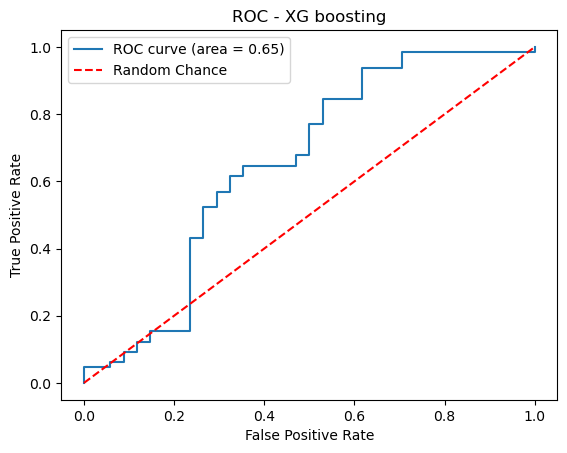

In [182]:
y_prediction = xg_boost.predict_proba(X_val_array)[:, 1]
y_pred_class = xg_boost.predict(X_val_array) 
y_pred_class = np.array(y_pred_class).reshape(-1,1)

#print(y_val_array)
#print(y_pred_class)

def accuracy(y_true, y_pred):
    ''' Function to compute accuracy '''

    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total = len(y_true)
    return correct / total

# Calculate accuracy
accuracy_xgb = accuracy(y_val_array, y_pred_class)
print(f"Accuracy of Boosting is: {accuracy_xgb}")

# Calculate the AUC
auc = roc_auc_score(y_val_array, y_prediction)

# Compute ROC curve and AUC using the test data
fpr, tpr, _ = roc_curve(y_val_array, y_prediction)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - XG boosting')
plt.legend()
plt.show()

Out of all different ratios of train_val_split (60-40, 70-30, 80-20, 90-10), 80-20 (80% training and 20% validation) gives a higher accuracy for both boosting(75.75%) and classification tree (68.68%).

The classification tree performs better than boosting. The reason for the better performance of classification trees: 

- Could have overfit the data. <br>
- XGBoost performs better on larger datasets, since the dataset is small decision trees could have performed better. <br>
- Dataset may have simple relationships that a decision tree can capture effectively without the need for the complexity that XGBoost offers. <br>
- Suboptimal performance of XGBoost due to ineffective tuning of hyperparameters. <br>

# Test Data

In [217]:
# Reading data into a dataframe
df_test = pd.read_csv('data_test-1.csv')

# printing the first 5 rows of the data
df_test.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0,LP002364,Male,Yes,0,Graduate,No,14880,0.0,96.0,360.0,1.0,Semiurban
1,1,LP001334,Male,Yes,0,Not Graduate,No,4188,0.0,115.0,180.0,1.0,Semiurban
2,2,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural
3,3,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural
4,4,LP001758,Male,Yes,2,Graduate,No,6250,1695.0,210.0,360.0,1.0,Semiurban


In [218]:
# printing the shape of the dataframe
print("Shape of the data", df_test.shape)

# printing the actual shape of the dataframe
df_test = df_test.iloc[:, 1:]
print("Actual size of data", df_test.shape)

Shape of the data (123, 13)
Actual size of data (123, 12)


In [219]:
print("Yes the data has some missing values \n")

# Counting missing values in each column
blank_sum_row = df_test.isnull().sum()
print("Total Blank Rows:\n", blank_sum_row)

# Counting total missing values
blank_sum = df_test.isnull().sum().sum()
print("Total Blank places:", blank_sum)

Yes the data has some missing values 

Total Blank Rows:
 Loan_ID              0
Gender               1
Married              0
Dependents           2
Education            0
Self_Employed        3
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           5
Loan_Amount_Term     2
Credit_History       7
Property_Area        0
dtype: int64
Total Blank places: 20


In [220]:
# Separate the dataset into categorical and continuous columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']
continuous_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History']

print("\n Categorical Variables:", categorical_cols)
print("\n Continuous Variables:", continuous_cols)

categorical_df = df_test[categorical_cols]
continuous_df = df_test[continuous_cols]

categorical_df.fillna(categorical_df.mode(axis=0), inplace=True)
continuous_df.fillna(continuous_df.mean(), inplace=True)


 Categorical Variables: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

 Continuous Variables: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


C:\Users\arun2\AppData\Local\Temp\ipykernel_17172\3374420063.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_df.fillna(categorical_df.mode(axis=0), inplace=True)
C:\Users\arun2\AppData\Local\Temp\ipykernel_17172\3374420063.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  continuous_df.fillna(continuous_df.mean(), inplace=True)


In [221]:
df_test = pd.concat([continuous_df, categorical_df], axis=1)

In [222]:
# Encoding the data
df_test['Gender'] = df_test['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df_test['Married'] = df_test['Married'].apply(lambda x: 1 if x == 'Yes' else 0)
df_test['Education'] = df_test['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)
df_test['Self_Employed'] = df_test['Self_Employed'].apply(lambda x: 1 if x == 'Yes' else 0)

# Mapping the categorical variables to numericals
mapping_propertyarea = {'Rural': 0, 'Semiurban': 1, 'Urban': 2}
df_test['Property_Area'] = df_test['Property_Area'].replace(mapping_propertyarea)

# Mapping the categorical variables to numericals
mapping_dependents = {'0': 0, '1': 1, '2': 2, '3+': 3}
df_test['Dependents'] = df_test['Dependents'].replace(mapping_dependents)

print(df_test)

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0              14880                0.0        96.0             360.0   
1               4188                0.0       115.0             180.0   
2               4106                0.0        40.0             180.0   
3               3340             1710.0       150.0             360.0   
4               6250             1695.0       210.0             360.0   
..               ...                ...         ...               ...   
118            12000                0.0       496.0             360.0   
119             6277                0.0       118.0             360.0   
120             1958             2436.0       131.0             360.0   
121             2060             2209.0       134.0             360.0   
122             3975             2531.0        55.0             360.0   

     Credit_History  Gender  Married  Dependents  Education  Self_Employed  \
0               1.0       1        1         

In [223]:
# Extracting the features after encoding
X_test = df_test.iloc[:,0:12]
X_test_array = X_test.to_numpy()
print(X_test_array)
X_test_array.shape

[[1.488e+04 0.000e+00 9.600e+01 ... 1.000e+00 0.000e+00 1.000e+00]
 [4.188e+03 0.000e+00 1.150e+02 ... 0.000e+00 0.000e+00 1.000e+00]
 [4.106e+03 0.000e+00 4.000e+01 ... 1.000e+00 0.000e+00 0.000e+00]
 ...
 [1.958e+03 2.436e+03 1.310e+02 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.060e+03 2.209e+03 1.340e+02 ... 1.000e+00 0.000e+00 1.000e+00]
 [3.975e+03 2.531e+03 5.500e+01 ... 0.000e+00 0.000e+00 0.000e+00]]


(123, 11)

In [224]:
y_pred_classification_tree = best_model.predict(X_test_array)
y_pred_xgboost = xg_boost.predict(X_test_array) 

In [225]:
print(y_pred_classification_tree)
print(len(y_pred_classification_tree))

[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
123


In [226]:
print(y_pred_xgboost)
print(len(y_pred_xgboost))

[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0
 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 0 0 1 1]
123


In [227]:
y_pred_classification_tree = np.array(y_pred_classification_tree)
y_pred_xgboost = np.array(y_pred_xgboost)

In [228]:
y_pred_classification_tree_main = np.where(y_pred_classification_tree == 1, 'Y' ,'N')
y_pred_xgboost_main = np.where(y_pred_xgboost == 1, 'Y' ,'N')

In [229]:
final_inference = pd.DataFrame({
    'pred_tree' : y_pred_classification_tree_main.reshape(123,),
    'pred_xgboost' : y_pred_xgboost_main.reshape(123,)
})

final_inference.to_csv('Arunachalam_Venkatachalam_preds.csv', index=False)